# Dataset

In [ ]:
!gdown 1ZDWMAPgRblVo7-P88oIbwmmk7dc3y4aL
!gdown 1HnpVM3AaypWhopdRCIBGP_kmFyxOVNMH

Downloading...
From: https://drive.google.com/uc?id=1ZDWMAPgRblVo7-P88oIbwmmk7dc3y4aL
To: /content/recipe_dataset_processed_filtered.parquet
100% 5.42M/5.42M [00:00<00:00, 121MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HnpVM3AaypWhopdRCIBGP_kmFyxOVNMH
To: /content/google_locals_dataset_processed_filtered.parquet
100% 1.05M/1.05M [00:00<00:00, 34.1MB/s]


In [ ]:
import pandas as pd
df_rating = pd.read_parquet('/content/recipe_dataset_processed_filtered.parquet')

df_rating = pd.read_parquet('/content/google_locals_dataset_processed_filtered.parquet')

In [ ]:
df_rating

In [ ]:
df_5 = df_rating[df_rating.rating == 5.0]
df_1 = df_rating[df_rating.rating == 1.0]

In [ ]:
df_5

In [ ]:
df_1

# Representing the Reviews and overviews

In [ ]:
df_movies_inf = df_rating.reset_index()

In [ ]:
df_movies_inf

In [ ]:
!pip install sentence-transformers==2.2.2

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

sentences_review = df_movies_inf.review.replace(['\t','\n','\r'], [' ',' ',' '], regex=True)

sentences_overview = df_movies_inf.description.replace(['\t','\n','\r'], [' ',' ',' '], regex=True)

embeddings_overview = model.encode(sentences_overview)
embeddings_reviews = model.encode(sentences_review)

df_movies_inf['overview_embedding'] = list(embeddings_overview)
df_movies_inf['review_embedding'] = list(embeddings_reviews)

In [ ]:
df_interest = df_movies_inf[df_movies_inf.rating == 5.0]
df_outlier = df_movies_inf[df_movies_inf.rating == 1.0]

df_interest.to_pickle('df_interest.pkl')
df_outlier.to_pickle('df_outlier.pkl')

# Train-Test

In [ ]:
dataset = 'google/'
path = '/content/drive/MyDrive/USP/Doctorate/Research/Articles/Recommender Systems: One-Class Learning and Unsupervised Graph Neural Networks via Link Prediction/datasets/' + dataset

In [ ]:
import pandas as pd
df_int = pd.read_pickle(path + 'df_interest.pkl')
df_out = pd.read_pickle(path + 'df_outlier.pkl')

In [ ]:
from sklearn.model_selection import train_test_split

df_int = df_int.sample(10000, random_state=0)

df_train, df_test = train_test_split(df_int, test_size=0.2, random_state = 0)

In [ ]:
df_train

In [ ]:
df_test = df_test[(df_test.item_id.isin(df_train.item_id.unique())) & (df_test.user_id.isin(df_train.user_id.unique()))]
df_test                                                                

In [ ]:
df_out = df_out[(df_out.item_id.isin(df_train.item_id.unique())) & (df_out.user_id.isin(df_train.user_id.unique()))]
df_out

# Graph Modeling

In [ ]:
import networkx as nx

G = nx.Graph()

for _,row in df_train.iterrows():
  user = str(row['user_id']) + ';user'
  item = str(row['item_id']) + ';item'

  keywords = row.text_attributes

  G.add_edge(user,item)
  G.add_edge(item, str(row['item_id'])+ ';' + str(row['user_id']) + ';review')
  G.add_edge(user, str(row['item_id'])+ ';' + str(row['user_id']) + ';review')
  
  for keyword in keywords:
    G.add_edge(item,keyword + ';keyword')

In [ ]:
len(list(nx.connected_components(G)))

1

In [ ]:
for node in G.nodes:
  if 'item' in node:
    G.nodes[node]['overview'] = df_train[df_train.item_id == node.split(';')[0]].description
    G.nodes[node]['features'] = df_train[df_train.item_id == node.split(';')[0]].overview_embedding.iloc[0]
    G.nodes[node]['color'] = 0
    G.nodes[node]['type'] = 'item'
  elif 'user' in node:
    G.nodes[node]['color'] = 1
    G.nodes[node]['type'] = 'user'
  elif 'review' in node:
    G.nodes[node]['review'] = df_train[(df_train.item_id == node.split(';')[0]) & (df_train.user_id == node.split(';')[1])].review
    G.nodes[node]['features'] = df_train[(df_train.item_id == node.split(';')[0]) & (df_train.user_id == node.split(';')[1])].review_embedding.iloc[0]
    G.nodes[node]['color'] = 2
    G.nodes[node]['type'] = 'review'
  elif 'keyword' in node:
    G.nodes[node]['keyword'] = node.split(';')[0]
    G.nodes[node]['color'] = 3
    G.nodes[node]['type'] = 'keyword'

In [ ]:
len(G.nodes)

10231

# Regularization

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
import random


def regularization(G, dim, embedding_feature: str = 'features', iterations=15, mi=1.0):

    nodes = []

    # inicializando vetor f para todos os nodes
    for node in G.nodes():
        G.nodes[node]['f'] = np.array([0.0]*dim)
        if embedding_feature in G.nodes[node]:
            G.nodes[node]['f'] = G.nodes[node][embedding_feature]*1.0
        nodes.append(node)

    pbar = tqdm(range(0, iterations))

    for iteration in pbar:
        random.shuffle(nodes)
        energy = 0.0

        # percorrendo cada node
        for node in nodes:
            f_new = np.array([0.0]*dim)
            f_old = np.array(G.nodes[node]['f'])*1.0
            sum_w = 0.0
            w = 1.0

            # percorrendo vizinhos do node
            for neighbor in G.neighbors(node):

                w /= np.sqrt(G.degree[neighbor])
                
                f_new = f_new + (w * G.nodes[neighbor]['f'])

                sum_w += w

            f_new /= sum_w

            G.nodes[node]['f'] = f_new*1.0

            if embedding_feature in G.nodes[node]:
                G.nodes[node]['f'] = G.nodes[node][embedding_feature] * \
                    mi + G.nodes[node]['f']*(1.0-mi)

            energy += np.linalg.norm(f_new-f_old)


        iteration += 1
        message = 'Iteration '+str(iteration)+' | Energy = '+str(energy)
        pbar.set_description(message)

    return G

In [ ]:
dim = len(df_train.review_embedding.iloc[0])

G2 = regularization(G, dim, iterations=5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
for node in G2.nodes():
  if 'features' in G2.nodes[node]:
    G2.nodes[node]['f'] = G.nodes[node]['features']

# Unsupervised Link Prediction

In [ ]:
!git clone https://github.com/stellargraph/stellargraph.git

In [ ]:
cd stellargraph

In [ ]:
!pip install -r requirements.txt

In [ ]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets

from tensorflow.keras.callbacks import EarlyStopping
from stellargraph.utils import plot_history

import tensorflow as tf
import stellargraph
from stellargraph import StellarGraph

In [ ]:
from stellargraph import StellarGraph
G = StellarGraph.from_networkx(G2,node_features='f')
G

In [ ]:
print(G.info())

In [ ]:
def gcn_experimental_loop(EXPERIMENTAL_SEED, P_FRAC, epoch, patience, layer_sizes, activations, dropout, lr):

  # Define an edge splitter on the original graph G:
  edge_splitter_test = EdgeSplitter(G)

  # Randomly sample a fraction p=P_FRAC of all positive links, and same number of negative links, from G, and obtain the
  # reduced graph G_test with the sampled links removed:
  G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
      p=P_FRAC, method="global", keep_connected=False,seed=EXPERIMENTAL_SEED
  )

  # Define an edge splitter on the reduced graph G_test:
  edge_splitter_train = EdgeSplitter(G_test)

  # Randomly sample a fraction p=P_FRAC of all positive links, and same number of negative links, from G_test, and obtain the
  # reduced graph G_train with the sampled links removed:
  G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
      p=P_FRAC, method="global", keep_connected=False,seed=EXPERIMENTAL_SEED
  )

  train_gen = FullBatchLinkGenerator(G_train, method="gcn")
  train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

  test_gen = FullBatchLinkGenerator(G_test, method="gcn")
  test_flow = train_gen.flow(edge_ids_test, edge_labels_test)


  gcn = GCN(
      layer_sizes=layer_sizes, activations=activations, generator=train_gen, dropout=dropout
  )

  x_inp, x_out = gcn.in_out_tensors()

  prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

  prediction = keras.layers.Reshape((-1,))(prediction)

  model = keras.Model(inputs=x_inp, outputs=prediction)

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=lr),
      loss=keras.losses.binary_crossentropy,
      metrics=[keras.metrics.BinaryAccuracy()],
  )

  init_train_metrics = model.evaluate(train_flow)
  init_test_metrics = model.evaluate(test_flow)

  es = EarlyStopping(monitor="loss", min_delta=0, patience=patience)

  history = model.fit(
      train_flow, epochs=epoch, validation_data=test_flow, verbose=1, shuffle=False, callbacks=[es])

  train_metrics = model.evaluate(train_flow)
  test_metrics = model.evaluate(test_flow)

  print("\nTest Set Metrics of the trained model:")
  L = []
  for name, val in zip(model.metrics_names, test_metrics):
      print(name,val,len(edge_ids_train)/2,len(edge_ids_test)/2,EXPERIMENTAL_SEED,P_FRAC)
      L.append([name,val,len(edge_ids_train)/2,len(edge_ids_test)/2,EXPERIMENTAL_SEED,P_FRAC])

  return L, model, history

In [ ]:
tf.random.set_seed(81)
stellargraph.random.set_seed(81)

L, model, hist = gcn_experimental_loop(42, 0.4, 200, 50, [64], ['tanh'], 0.1, 0.0001)

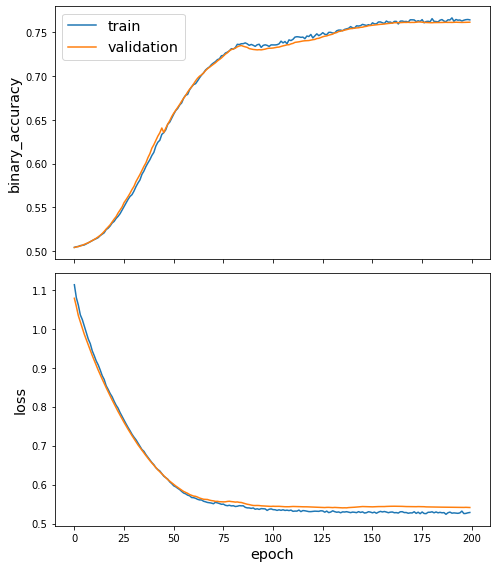

In [ ]:
plot_history(hist)

In [ ]:
embedding_generator = keras.Model(inputs=model.input, outputs=model.layers[5].output)

gen = FullBatchLinkGenerator(G, method="gcn")
flow = gen.flow(G2.edges, [1] * len((G2.edges)))

embeddings = embedding_generator.predict(flow)

df_gnn = pd.DataFrame(index = G2.nodes)
df_gnn['emb_gnn'] = list(embeddings[0])

df_gnn['BERT_reg'] = pd.Series(nx.get_node_attributes(G2, "f"))

Using GCN (local pooling) filters...
1/1 [==============================] - 0s 181ms/step


## link prediction da gnn


In [ ]:
from sklearn.metrics import classification_report
edges = []
for index,row in df_test.iterrows():
  user = str(row['user_id']) + ';user'
  item = str(row['item_id']) + ';item'

  edges.append((user,item))

for index,row in df_out.iterrows():
  user = str(row['user_id']) + ';user'
  item = str(row['item_id']) + ';item'

  edges.append((user,item))

y_true = [1] * len(df_test) + [0] * len(df_out)

flow = gen.flow(edges, y_true)

predicts = model.predict(flow)

preds = [1 if p > 0 else 0 for p in predicts[0]]

print(classification_report(y_true, preds, output_dict=False))

1/1 [==============================] - 0s 241ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1478
           1       0.57      1.00      0.73      1973

    accuracy                           0.57      3451
   macro avg       0.29      0.50      0.36      3451
weighted avg       0.33      0.57      0.42      3451



# One-Class Recommendation


In [ ]:
from sklearn.metrics import classification_report
from sklearn.svm import OneClassSVM as OCSVM

def evaluation_one_class(preds_interest, preds_outliers):
    y_true = [1] * len(preds_interest) + [-1] * len(preds_outliers)
    y_pred = list(preds_interest) + list(preds_outliers)
    return print(classification_report(y_true, y_pred, output_dict=False))

def fast_result(column, nu):
  emb_train = []
  emb_test = []
  emb_out = []

  for item,row in df_train.iterrows():
    user = str(row['user_id']) + ';user'
    item = str(row['item_id']) + ';item'

    emb_train.append(np.concatenate([df_gnn.loc[user][column], df_gnn.loc[item][column]]))

  for item,row in df_test.iterrows():
    user = str(row['user_id']) + ';user'
    item = str(row['item_id']) + ';item'

    if user in G.nodes() and item in G.nodes():
      emb_test.append(np.concatenate([df_gnn.loc[user][column], df_gnn.loc[item][column]]))

  for item,row in df_out.iterrows():
    user = str(row['user_id']) + ';user'
    item = str(row['item_id']) + ';item'

    if user in G.nodes() and item in G.nodes():
      emb_out.append(np.concatenate([df_gnn.loc[user][column], df_gnn.loc[item][column]]))

  one_class_classifier = OCSVM(nu=nu, kernel='rbf', gamma='auto').fit(emb_train)

  Y_pred_interest = one_class_classifier.predict(emb_test)
  Y_pred_ruido = one_class_classifier.predict(emb_out)

  evaluation_one_class(Y_pred_interest, Y_pred_ruido)

In [ ]:
fast_result('emb_gnn', 0.2)

              precision    recall  f1-score   support

          -1       0.51      0.34      0.41      1478
           1       0.61      0.76      0.67      1973

    accuracy                           0.58      3451
   macro avg       0.56      0.55      0.54      3451
weighted avg       0.57      0.58      0.56      3451



In [ ]:
fast_result('BERT_reg', 0.2)

              precision    recall  f1-score   support

          -1       0.40      0.18      0.25      1478
           1       0.56      0.79      0.66      1973

    accuracy                           0.53      3451
   macro avg       0.48      0.49      0.45      3451
weighted avg       0.49      0.53      0.48      3451



# Pipeline

In [ ]:
!git clone https://github.com/stellargraph/stellargraph.git

In [ ]:
cd stellargraph

In [ ]:
!pip install -r requirements.txt

In [ ]:
dataset = 'google'

In [ ]:
path = '/content/drive/MyDrive/USP/Doctorate/Research/Articles/Recommender Systems: One-Class Learning and Unsupervised Graph Neural Networks via Link Prediction/datasets/' + dataset

In [ ]:
import pandas as pd
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding
from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import globalvar
from stellargraph import datasets
from tensorflow.keras.callbacks import EarlyStopping
from stellargraph.utils import plot_history
import tensorflow as tf
import stellargraph
from stellargraph import StellarGraph

df_int = pd.read_pickle(path + 'df_interest.pkl')
df_int = df_int.sample(10000, random_state=0)
df_out = pd.read_pickle(path + 'df_outlier.pkl')

In [ ]:
from sklearn.metrics import classification_report
from sklearn.svm import OneClassSVM as OCSVM

def result_ocl_recommendation(ocsvm, emb_train, emb_test, emb_out):
  
  one_class_classifier = ocsvm.fit(emb_train)

  preds_interest = one_class_classifier.predict(emb_test)
  preds_outliers = one_class_classifier.predict(emb_out)

  y_true = [1] * len(preds_interest) + [-1] * len(preds_outliers)
  y_pred = list(preds_interest) + list(preds_outliers)

  return classification_report(y_true, y_pred, output_dict=True)

def reps_for_ocl(column, df_train, df_test, df_out, df_gnn, G):
  emb_train = []
  emb_test = []
  emb_out = []

  for item,row in df_train.iterrows():
    user = str(row['user_id']) + ';user'
    item = str(row['item_id']) + ';item'

    emb_train.append(np.concatenate([df_gnn.loc[user][column], df_gnn.loc[item][column]]))

  for item,row in df_test.iterrows():
    user = str(row['user_id']) + ';user'
    item = str(row['item_id']) + ';item'

    if user in G.nodes() and item in G.nodes():
      emb_test.append(np.concatenate([df_gnn.loc[user][column], df_gnn.loc[item][column]]))

  for item,row in df_out.iterrows():
    user = str(row['user_id']) + ';user'
    item = str(row['item_id']) + ';item'

    if user in G.nodes() and item in G.nodes():
      emb_out.append(np.concatenate([df_gnn.loc[user][column], df_gnn.loc[item][column]]))

  return emb_train, emb_test, emb_out

def reps_for_ocl_movie(column, df_train, df_test, df_out):
  emb_train = []
  emb_test = []
  emb_out = []

  users = df_train['user_id'].unique() 
  items = df_train['item_id'].unique() 

  for idx,row in df_train.iterrows():
    emb_train.append(row[column])

  for idx,row in df_test.iterrows():
    user = row['user_id']
    item = row['item_id']
    if user in users and item in items:
      emb_test.append(row[column])

  for idx,row in df_out.iterrows():
    user = row['user_id']
    item = row['item_id']

    if user in users and item in items:
      emb_out.append(row[column])

  return emb_train, emb_test, emb_out

In [ ]:
import random

def gcn_experimental_loop(G, EXPERIMENTAL_SEED, P_FRAC, epoch, patience, layer_sizes, activations, dropout, lr):

  edge_splitter_test = EdgeSplitter(G)

  G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
      p=P_FRAC, method="global", keep_connected=False,seed=EXPERIMENTAL_SEED
  )

  edge_splitter_train = EdgeSplitter(G_test)

  G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
      p=P_FRAC, method="global", keep_connected=False,seed=EXPERIMENTAL_SEED
  )

  train_gen = FullBatchLinkGenerator(G_train, method="gcn")
  train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

  test_gen = FullBatchLinkGenerator(G_test, method="gcn")
  test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

  gcn = GCN(
      layer_sizes=layer_sizes, activations=activations, generator=train_gen, dropout=dropout
  )

  x_inp, x_out = gcn.in_out_tensors()

  prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

  prediction = keras.layers.Reshape((-1,))(prediction)

  model = keras.Model(inputs=x_inp, outputs=prediction)

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=lr),
      loss=keras.losses.binary_crossentropy,
      metrics=[keras.metrics.BinaryAccuracy()],
  )

  init_train_metrics = model.evaluate(train_flow)
  init_test_metrics = model.evaluate(test_flow)

  es = EarlyStopping(monitor="loss", min_delta=0, patience=patience)

  model.fit(train_flow, epochs=epoch, validation_data=test_flow, verbose=0, shuffle=False, callbacks=[es])

  return model

def regularization(G, dim, embedding_feature: str = 'features', iterations=15, mi=1.0):

    nodes = []

    # inicializando vetor f para todos os nodes
    for node in G.nodes():
        G.nodes[node]['f'] = np.array([0.0]*dim)
        if embedding_feature in G.nodes[node]:
            G.nodes[node]['f'] = G.nodes[node][embedding_feature]*1.0
        nodes.append(node)

    random.seed(81)
    for iteration in range(iterations):
        random.shuffle(nodes)
        energy = 0.0

        # percorrendo cada node
        for node in nodes:
            f_new = np.array([0.0]*dim)
            f_old = np.array(G.nodes[node]['f'])*1.0
            sum_w = 0.0
            w = 1.0

            # percorrendo vizinhos do node
            for neighbor in G.neighbors(node):

                w /= np.sqrt(G.degree[neighbor])
                
                f_new = f_new + (w * G.nodes[neighbor]['f'])

                sum_w += w

            f_new /= sum_w

            G.nodes[node]['f'] = f_new*1.0

            if embedding_feature in G.nodes[node]:
                G.nodes[node]['f'] = G.nodes[node][embedding_feature] * \
                    mi + G.nodes[node]['f']*(1.0-mi)

            energy += np.linalg.norm(f_new-f_old)

        iteration += 1

    return G

In [ ]:
import numpy as np
import pandas as pd
from gc import collect
from sklearn.model_selection import KFold
from pathlib import Path
import networkx as nx

def train_test_split_ocl_recommendation(kf, df_int):
    train_test = []

    for train_index, test_index in kf.split(df_int):
        train_test.append((df_int.iloc[train_index], df_int.iloc[test_index]))
    
    return train_test

def foldValidation(folds):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    return kf

def generate_graph_enriched(df_train):
  G = nx.Graph()

  for _,row in df_train.iterrows():
    user = str(row['user_id']) + ';user'
    item = str(row['item_id']) + ';item'

    keywords = row.text_attributes

    G.add_edge(user,item)
    G.add_edge(item, str(row['item_id'])+ ';' + str(row['user_id']) + ';review')
    G.add_edge(user, str(row['item_id'])+ ';' + str(row['user_id']) + ';review')
    
    for keyword in keywords:
      G.add_edge(item,keyword + ';keyword')

    
  for node in G.nodes:
    if 'item' in node:
      G.nodes[node]['overview'] = df_train[df_train.item_id == node.split(';')[0]].description
      G.nodes[node]['features'] = df_train[df_train.item_id == node.split(';')[0]].overview_embedding.iloc[0]
      G.nodes[node]['type'] = 'item'
    elif 'user' in node:
      G.nodes[node]['type'] = 'user'
    elif 'review' in node:
      G.nodes[node]['review'] = df_train[(df_train.item_id == node.split(';')[0]) & (df_train.user_id == node.split(';')[1])].review
      G.nodes[node]['features'] = df_train[(df_train.item_id == node.split(';')[0]) & (df_train.user_id == node.split(';')[1])].review_embedding.iloc[0]
      G.nodes[node]['type'] = 'review'
    elif 'keyword' in node:
      G.nodes[node]['keyword'] = node.split(':')[0]
      G.nodes[node]['type'] = 'keyword'

  dim = len(df_train.review_embedding.iloc[0])

  G2 = regularization(G, dim, iterations=5)

  for node in G2.nodes():
    if 'features' in G2.nodes[node]:
      G2.nodes[node]['f'] = G.nodes[node]['features']

  G3 = StellarGraph.from_networkx(G2,node_features='f')

  return G3, G2

def generate_original_graph(df_train):
  G = nx.Graph()

  for _,row in df_train.iterrows():
    user = str(row['user_id']) + ';user'
    item = str(row['item_id']) + ';item'

    keywords = row.text_attributes

    G.add_edge(user,item)
    
  for node in G.nodes:
    if 'item' in node:
      G.nodes[node]['overview'] = df_train[df_train.item_id == node.split(';')[0]].description
      G.nodes[node]['features'] = df_train[df_train.item_id == node.split(';')[0]].overview_embedding.iloc[0]
      G.nodes[node]['type'] = 'item'
    elif 'user' in node:
      G.nodes[node]['type'] = 'user'

  dim = len(df_train.review_embedding.iloc[0])

  G2 = regularization(G, dim, iterations=5)

  for node in G2.nodes():
    if 'features' in G2.nodes[node]:
      G2.nodes[node]['f'] = G.nodes[node]['features']

  G3 = StellarGraph.from_networkx(G2,node_features='f')

  return G3, G2
  
def write_results(l_values, file_name, line_parameters, path):
    if not Path(path + file_name).is_file():
        file_ = open(path + file_name, 'w')
        string = 'Parameters'

        for i in range(1,6):
            string += ';fold' + str(i)
        string += '\n'

        file_.write(string)
        file_.close()

    file_ = open(path + file_name, 'a')
    string = line_parameters

    for values in l_values:
        string += ';' + str(values)

    string += '\n'
    file_.write(string)
    file_.close()

In [ ]:
from sklearn.svm import OneClassSVM as OCSVM

epoch = 200

n_neurons = [[32], [64, 32]]

lrs = [0.001,0.0001]

dropouts = [0.3,0.4]

patiences = [20, 50]

activations = {1:[['tanh'], ['sigmoid']],
                2:[['tanh', 'tanh'], ['sigmoid', 'sigmoid']],
                3:[['tanh', 'tanh', 'tanh'], ['sigmoid', 'sigmoid', 'sigmoid']]}

layer_output_emb = {1: 5,
                    2: 7,
                    3: 9}

EXPERIMENTAL_SEED = 81
P_FRAC = 0.4

models = {
	'OCSVM_RBF_0.001_auto': OCSVM(kernel='rbf', nu=0.001, gamma='auto'),
	'OCSVM_RBF_0.005_auto': OCSVM(kernel='rbf', nu=0.005, gamma='auto'),
	'OCSVM_RBF_0.01_auto': OCSVM(kernel='rbf', nu=0.01, gamma='auto'),
	'OCSVM_RBF_0.05_auto': OCSVM(kernel='rbf', nu=0.05, gamma='auto'),
	'OCSVM_RBF_0.1_auto': OCSVM(kernel='rbf', nu=0.1, gamma='auto'),
	'OCSVM_RBF_0.2_auto': OCSVM(kernel='rbf', nu=0.2, gamma='auto'),
	'OCSVM_RBF_0.3_auto': OCSVM(kernel='rbf', nu=0.3, gamma='auto'),
	'OCSVM_RBF_0.4_auto': OCSVM(kernel='rbf', nu=0.4, gamma='auto'),
	'OCSVM_RBF_0.5_auto': OCSVM(kernel='rbf', nu=0.5, gamma='auto'),
	'OCSVM_RBF_0.6_auto': OCSVM(kernel='rbf', nu=0.6, gamma='auto'),
	'OCSVM_RBF_0.7_auto': OCSVM(kernel='rbf', nu=0.7, gamma='auto'),
	'OCSVM_sigmoid_0.001_auto': OCSVM(kernel='sigmoid', nu=0.001, gamma='auto'),
	'OCSVM_sigmoid_0.005_auto': OCSVM(kernel='sigmoid', nu=0.005, gamma='auto'),
	'OCSVM_sigmoid_0.01_auto': OCSVM(kernel='sigmoid', nu=0.01, gamma='auto'),
	'OCSVM_sigmoid_0.05_auto': OCSVM(kernel='sigmoid', nu=0.05, gamma='auto'),
	'OCSVM_sigmoid_0.1_auto': OCSVM(kernel='sigmoid', nu=0.1, gamma='auto'),
	'OCSVM_sigmoid_0.2_auto': OCSVM(kernel='sigmoid', nu=0.2, gamma='auto'),
	'OCSVM_sigmoid_0.3_auto': OCSVM(kernel='sigmoid', nu=0.3, gamma='auto'),
	'OCSVM_sigmoid_0.4_auto': OCSVM(kernel='sigmoid', nu=0.4, gamma='auto'),
	'OCSVM_sigmoid_0.5_auto': OCSVM(kernel='sigmoid', nu=0.5, gamma='auto'),
	'OCSVM_sigmoid_0.6_auto': OCSVM(kernel='sigmoid', nu=0.6, gamma='auto'),
	'OCSVM_sigmoid_0.7_auto': OCSVM(kernel='sigmoid', nu=0.7, gamma='auto'),
	'OCSVM_poly_0.001_auto': OCSVM(kernel='poly', nu=0.001, gamma='auto'),
	'OCSVM_poly_0.005_auto': OCSVM(kernel='poly', nu=0.005, gamma='auto'),
	'OCSVM_poly_0.01_auto': OCSVM(kernel='poly', nu=0.01, gamma='auto'),
	'OCSVM_poly_0.05_auto': OCSVM(kernel='poly', nu=0.05, gamma='auto'),
	'OCSVM_poly_0.1_auto': OCSVM(kernel='poly', nu=0.1, gamma='auto'),
	'OCSVM_poly_0.2_auto': OCSVM(kernel='poly', nu=0.2, gamma='auto'),
	'OCSVM_poly_0.3_auto': OCSVM(kernel='poly', nu=0.3, gamma='auto'),
	'OCSVM_poly_0.4_auto': OCSVM(kernel='poly', nu=0.4, gamma='auto'),
	'OCSVM_poly_0.5_auto': OCSVM(kernel='poly', nu=0.5, gamma='auto'),
	'OCSVM_poly_0.6_auto': OCSVM(kernel='poly', nu=0.6, gamma='auto'),
	'OCSVM_poly_0.7_auto': OCSVM(kernel='poly', nu=0.7, gamma='auto'),
	'OCSVM_linear_0.001_auto': OCSVM(kernel='linear', nu=0.001, gamma='auto'),
	'OCSVM_linear_0.005_auto': OCSVM(kernel='linear', nu=0.005, gamma='auto'),
	'OCSVM_linear_0.01_auto': OCSVM(kernel='linear', nu=0.01, gamma='auto'),
	'OCSVM_linear_0.05_auto': OCSVM(kernel='linear', nu=0.05, gamma='auto'),
	'OCSVM_linear_0.1_auto': OCSVM(kernel='linear', nu=0.1, gamma='auto'),
	'OCSVM_linear_0.2_auto': OCSVM(kernel='linear', nu=0.2, gamma='auto'),
	'OCSVM_linear_0.3_auto': OCSVM(kernel='linear', nu=0.3, gamma='auto'),
	'OCSVM_linear_0.4_auto': OCSVM(kernel='linear', nu=0.4, gamma='auto'),
	'OCSVM_linear_0.5_auto': OCSVM(kernel='linear', nu=0.5, gamma='auto'),
	'OCSVM_linear_0.6_auto': OCSVM(kernel='linear', nu=0.6, gamma='auto'),
	'OCSVM_linear_0.7_auto': OCSVM(kernel='linear', nu=0.7, gamma='auto')   
}

## run

### GNN enriched

In [ ]:
import warnings
warnings.simplefilter("ignore")

from tqdm.notebook import tqdm

folds = 5
kf = foldValidation(folds)
train_test = train_test_split_ocl_recommendation(kf, df_int)

file_name = dataset + '_GNN_enriched_OCSVM.csv'

path = '/content/drive/MyDrive/USP/Doctorate/Research/Articles/Recommender Systems: One-Class Learning and Unsupervised Graph Neural Networks via Link Prediction/results/'

pbar = tqdm(range(0, len(n_neurons)))

for i in pbar:
  n_neuron = n_neurons[i]
  for lr in lrs:
    for dropout in dropouts:
      for patience in patiences:
        for activation in activations[len(n_neuron)]:
          representations = []
          for df_train, df_test in train_test:
            G, G2 = generate_graph_enriched(df_train)

            tf.random.set_seed(81)
            stellargraph.random.set_seed(81)

            model = gcn_experimental_loop(G, EXPERIMENTAL_SEED, P_FRAC, epoch, patience, n_neuron, activation, dropout, lr)

            embedding_generator = keras.Model(inputs=model.input, outputs=model.layers[layer_output_emb[len(n_neuron)]].output)

            gen = FullBatchLinkGenerator(G, method="gcn")
            flow = gen.flow(G2.edges, [1] * len((G2.edges)))

            embeddings = embedding_generator.predict(flow)

            df_gnn = pd.DataFrame(index = G2.nodes)
            df_gnn['emb_gnn'] = list(embeddings[0])
            x_train,x_test,x_outlier = reps_for_ocl('emb_gnn', df_train, df_test, df_out, df_gnn, G)
            representations.append((x_train,x_test,x_outlier))
            
          for model_cl in models.keys():
            ocsvm = models[model_cl]
            l_dicts = []
            for emb_train, emb_test, emb_out in representations:
              dic_result = result_ocl_recommendation(ocsvm, emb_train, emb_test, emb_out)
              l_dicts.append(dic_result)            

            parameters = str(n_neuron) + '_' + str(lr) + '_' + str(dropout) + '_' + str(patience) + '_' + str(activation) + '_' + str(model_cl)
            write_results(l_dicts, file_name, parameters, path)

### GNN original

In [ ]:
import warnings
warnings.simplefilter("ignore")

from tqdm.notebook import tqdm

folds = 5
kf = foldValidation(folds)
train_test = train_test_split_ocl_recommendation(kf, df_int)

file_name = dataset + '_GNN_original_OCSVM.csv'

path = '/content/drive/MyDrive/USP/Doctorate/Research/Articles/Recommender Systems: One-Class Learning and Unsupervised Graph Neural Networks via Link Prediction/results/'

pbar = tqdm(range(0, len(n_neurons)))

for i in pbar:
  n_neuron = n_neurons[i]
  for lr in lrs:
    for dropout in dropouts:
      for patience in patiences:
        for activation in activations[len(n_neuron)]:
          representations = []
          for df_train, df_test in train_test:
            G, G2 = generate_original_graph(df_train)

            tf.random.set_seed(81)
            stellargraph.random.set_seed(81)

            model = gcn_experimental_loop(G, EXPERIMENTAL_SEED, P_FRAC, epoch, patience, n_neuron, activation, dropout, lr)

            embedding_generator = keras.Model(inputs=model.input, outputs=model.layers[layer_output_emb[len(n_neuron)]].output)

            gen = FullBatchLinkGenerator(G, method="gcn")
            flow = gen.flow(G2.edges, [1] * len((G2.edges)))

            embeddings = embedding_generator.predict(flow)

            df_gnn = pd.DataFrame(index = G2.nodes)
            df_gnn['emb_gnn'] = list(embeddings[0])
            x_train,x_test,x_outlier = reps_for_ocl('emb_gnn', df_train, df_test, df_out, df_gnn, G)
            representations.append((x_train,x_test,x_outlier))
            
          for model_cl in models.keys():
            ocsvm = models[model_cl]
            l_dicts = []
            for emb_train, emb_test, emb_out in representations:
              dic_result = result_ocl_recommendation(ocsvm, emb_train, emb_test, emb_out)
              l_dicts.append(dic_result)            

            parameters = str(n_neuron) + '_' + str(lr) + '_' + str(dropout) + '_' + str(patience) + '_' + str(activation) + '_' + str(model_cl)
            write_results(l_dicts, file_name, parameters, path)

### BERT original

In [ ]:
import warnings
warnings.simplefilter("ignore")

from tqdm.notebook import tqdm

folds = 5
kf = foldValidation(folds)
train_test = train_test_split_ocl_recommendation(kf, df_int)

file_name = dataset + '_BERT_regularized_original_OCSVM.csv'

path = '/content/drive/MyDrive/USP/Doctorate/Research/Articles/Recommender Systems: One-Class Learning and Unsupervised Graph Neural Networks via Link Prediction/results/'

representations = []

for df_train, df_test in train_test:
  G, G2 = generate_original_graph(df_train)

  df_gnn = pd.DataFrame(index = G2.nodes)
  df_gnn['BERT_reg'] = pd.Series(nx.get_node_attributes(G2, "f"))

  x_train,x_test,x_outlier = reps_for_ocl('BERT_reg', df_train, df_test, df_out, df_gnn, G)
  representations.append((x_train,x_test,x_outlier))

for model_cl in models.keys():
  ocsvm = models[model_cl]
  l_dicts = []
  for emb_train, emb_test, emb_out in representations:
    dic_result = result_ocl_recommendation(ocsvm, emb_train, emb_test, emb_out)
    l_dicts.append(dic_result)            

  parameters = str(model_cl)
  write_results(l_dicts, file_name, parameters, path)

### BERT enriched

In [ ]:
path = '/content/drive/MyDrive/USP/Doctorate/Research/Articles/Recommender Systems: One-Class Learning and Unsupervised Graph Neural Networks via Link Prediction/results/'

folds = 5
kf = foldValidation(folds)
train_test = train_test_split_ocl_recommendation(kf, df_int)

file_name = dataset + '_BERT_regularized_enriched_OCSVM.csv'

representations = []

for df_train, df_test in train_test:
  G, G2 = generate_graph_enriched(df_train)

  df_gnn = pd.DataFrame(index = G2.nodes)
  df_gnn['BERT_reg'] = pd.Series(nx.get_node_attributes(G2, "f"))

  x_train,x_test,x_outlier = reps_for_ocl('BERT_reg', df_train, df_test, df_out, df_gnn, G)
  representations.append((x_train,x_test,x_outlier))

for model_cl in models.keys():
  ocsvm = models[model_cl]
  l_dicts = []
  for emb_train, emb_test, emb_out in representations:
    dic_result = result_ocl_recommendation(ocsvm, emb_train, emb_test, emb_out)
    l_dicts.append(dic_result)            

  parameters = str(model_cl)
  write_results(l_dicts, file_name, parameters, path)

### BERT item


In [ ]:
path = '/content/drive/MyDrive/USP/Doctorate/Research/Articles/Recommender Systems: One-Class Learning and Unsupervised Graph Neural Networks via Link Prediction/results/'

folds = 5
kf = foldValidation(folds)
train_test = train_test_split_ocl_recommendation(kf, df_int)

file_name = dataset + '_BERT_item_OCSVM.csv'

representations = []

for df_train, df_test in train_test:
  x_train,x_test,x_outlier = reps_for_ocl_movie('overview_embedding', df_train, df_test, df_out)
  representations.append((x_train,x_test,x_outlier))

for model_cl in models.keys():
  ocsvm = models[model_cl]
  l_dicts = []
  for emb_train, emb_test, emb_out in representations:
    dic_result = result_ocl_recommendation(ocsvm, emb_train, emb_test, emb_out)
    l_dicts.append(dic_result)            

  parameters = str(model_cl)
  write_results(l_dicts, file_name, parameters, path)

### GNN - End to End 

In [ ]:
import warnings
warnings.simplefilter("ignore")

from tqdm.notebook import tqdm

folds = 5
kf = foldValidation(folds)
train_test = train_test_split_ocl_recommendation(kf, df_int)

file_name = dataset + '_GNN_e_ETE.csv'

path = '/content/drive/MyDrive/USP/Doctorate/Research/Articles/Recommender Systems: One-Class Learning and Unsupervised Graph Neural Networks via Link Prediction/results/'

pbar = tqdm(range(0, len(n_neurons)))

for i in pbar:
  n_neuron = n_neurons[i]
  for lr in lrs:
    for dropout in dropouts:
      for patience in patiences:
        for activation in activations[len(n_neuron)]:
          l_dicts = []
          for df_train, df_test in train_test:
            G, G2 = generate_graph_enriched(df_train)
            tf.random.set_seed(81)
            stellargraph.random.set_seed(81)
            model = gcn_experimental_loop(G, EXPERIMENTAL_SEED, P_FRAC, epoch, patience, n_neuron, activation, dropout, lr)

            edges = []
            for index,row in df_test.iterrows():
              user = str(row['user_id']) + ';user'
              item = str(row['item_id']) + ';item'
              if user in G2.nodes() and item in G2.nodes():
                edges.append([user,item])

            y_true = [1] * len(edges)

            for index,row in df_out.iterrows():
              user = str(row['user_id']) + ';user'
              item = str(row['item_id']) + ';item'
              if user in G2.nodes() and item in G2.nodes():
                edges.append([user,item])

            y_true = y_true + [0] * (len(edges)- len(y_true))

            gen = FullBatchLinkGenerator(G, method="gcn") 

            test_flow = gen.flow(edges, y_true)

            predicts = model.predict(test_flow)

            preds = [1 if p > 0.5 else 0 for p in predicts[0]]

            dic_result = classification_report(y_true, preds, output_dict=True)
            l_dicts.append(dic_result)   
          
          parameters = str(n_neuron) + '_' + str(lr) + '_' + str(dropout) + '_' + str(patience) + '_' + str(activation)
          write_results(l_dicts, file_name, parameters, path)

# Results Analisys

In [4]:
import numpy as np
import pandas as pd
def show_results(df_result):

  dic_avg = {'f1-score' : [[],[]],
                'recall' : [[],[]],
                'precision' : [[],[]],
                'accuracy' : [[],[]]}

  for index,row in df_result.iterrows():
    dic_result = {'f1-score' : [],
                'recall' : [],
                'precision' : [],
                'accuracy' : []}

    for i in range(1,6):
      fold = 'fold' + str(i)
      for metric in ['f1-score','recall', 'precision']:
        dic_result[metric].append(eval(row[fold])['weighted avg'][metric])
      dic_result['accuracy'].append(eval(row[fold])['accuracy'])

    for metric in ['f1-score','recall', 'precision', 'accuracy']:
      dic_avg[metric][0].append(np.mean(dic_result[metric]))
      dic_avg[metric][1].append(np.std(dic_result[metric]))

  for metric in ['f1-score','recall', 'precision', 'accuracy']:
    df_result[metric + '-mean'] = dic_avg[metric][0]
    df_result[metric + '-std'] = dic_avg[metric][1]

  f1_max = max(df_result['f1-score-mean'])

  return f1_max

## BERT-item

In [54]:
!gdown 1-5IsUWwyMe5uIS0Jsth9m5vqJFoYL3-E

Downloading...
From: https://drive.google.com/uc?id=1-5IsUWwyMe5uIS0Jsth9m5vqJFoYL3-E
To: /content/stellargraph/Recipes_BERT_item_OCSVM.csv
100% 117k/117k [00:00<00:00, 62.9MB/s]


In [57]:
df_bert = pd.read_csv('Recipes_BERT_item_OCSVM.csv', sep=';')

f1_max = show_results(df_bert)

df_bert[df_bert['f1-score-mean'] == f1_max]

,Parameters,fold1,fold2,fold3,fold4,fold5,f1-score-mean,f1-score-std,recall-mean,recall-std,precision-mean,precision-std,accuracy-mean,accuracy-std
0,OCSVM_RBF_0.001_auto,"{'-1': {'precision': 0.20276497695852536, 'rec...","{'-1': {'precision': 0.2358974358974359, 'reca...","{'-1': {'precision': 0.23863636363636365, 'rec...","{'-1': {'precision': 0.22033898305084745, 'rec...","{'-1': {'precision': 0.32456140350877194, 'rec...",0.65998,0.005924,0.723556,0.011475,0.634913,0.01207,0.723556,0.011475


In [58]:
!gdown 1ro9ySeRw8uGmjKRmjl4Mvi8U97OvnsFc

Downloading...
From: https://drive.google.com/uc?id=1ro9ySeRw8uGmjKRmjl4Mvi8U97OvnsFc
To: /content/stellargraph/Google_BERT_item_OCSVM.csv
100% 117k/117k [00:00<00:00, 60.9MB/s]


In [59]:
df_bert = pd.read_csv('Google_BERT_item_OCSVM.csv', sep=';')

f1_max = show_results(df_bert)

df_bert[df_bert['f1-score-mean'] == f1_max]

,Parameters,fold1,fold2,fold3,fold4,fold5,f1-score-mean,f1-score-std,recall-mean,recall-std,precision-mean,precision-std,accuracy-mean,accuracy-std
11,OCSVM_sigmoid_0.001_auto,"{'-1': {'precision': 0.438386855862584, 'recal...","{'-1': {'precision': 0.44, 'recall': 0.3795721...","{'-1': {'precision': 0.43938223938223936, 'rec...","{'-1': {'precision': 0.3532608695652174, 'reca...","{'-1': {'precision': 0.4479495268138801, 'reca...",0.512361,0.026643,0.533541,0.006582,0.5143,0.018422,0.533541,0.006582


## BERT regularized original

In [1]:
!gdown 1-25aGKkyUIvZDJ1wuyC6pyZvBB3J_zVV

Downloading...
From: https://drive.google.com/uc?id=1-25aGKkyUIvZDJ1wuyC6pyZvBB3J_zVV
To: /content/Recipes_BERT_regularized_original_OCSVM.csv
100% 117k/117k [00:00<00:00, 51.7MB/s]


In [5]:
df_bert_ro = pd.read_csv('Recipes_BERT_regularized_original_OCSVM.csv', sep=';')

f1_max = show_results(df_bert_ro)

df_bert_ro[df_bert_ro['f1-score-mean'] == f1_max]

,Parameters,fold1,fold2,fold3,fold4,fold5,f1-score-mean,f1-score-std,recall-mean,recall-std,precision-mean,precision-std,accuracy-mean,accuracy-std
3,OCSVM_RBF_0.05_auto,"{'-1': {'precision': 0.27956989247311825, 'rec...","{'-1': {'precision': 0.26519337016574585, 'rec...","{'-1': {'precision': 0.31736526946107785, 'rec...","{'-1': {'precision': 0.31125827814569534, 'rec...","{'-1': {'precision': 0.2603550295857988, 'reca...",0.668034,0.004077,0.731017,0.005171,0.647743,0.007359,0.731017,0.005171


In [6]:
!gdown 1BfO5vRaiMg7Ouv0Ek-49EAaN6Tk59g1-

Downloading...
From: https://drive.google.com/uc?id=1BfO5vRaiMg7Ouv0Ek-49EAaN6Tk59g1-
To: /content/Google_BERT_regularized_original_OCSVM.csv
100% 118k/118k [00:00<00:00, 43.0MB/s]


In [13]:
df_bert_ro = pd.read_csv('Google_BERT_regularized_original_OCSVM.csv', sep=';')

f1_max = show_results(df_bert_ro)

df_bert_ro[df_bert_ro['f1-score-mean'] == f1_max]

,Parameters,fold1,fold2,fold3,fold4,fold5,f1-score-mean,f1-score-std,recall-mean,recall-std,precision-mean,precision-std,accuracy-mean,accuracy-std
6,OCSVM_RBF_0.3_auto,"{'-1': {'precision': 0.43853211009174314, 'rec...","{'-1': {'precision': 0.44033302497687327, 'rec...","{'-1': {'precision': 0.41509433962264153, 'rec...","{'-1': {'precision': 0.44972577696526506, 'rec...","{'-1': {'precision': 0.47763713080168774, 'rec...",0.526735,0.013895,0.539175,0.012635,0.52502,0.014331,0.539175,0.012635


## BERT regularized enriched

In [9]:
!gdown 1-7m3-dcULxD7-6vzSAawcFfvRdkjt7gJ

Downloading...
From: https://drive.google.com/uc?id=1-7m3-dcULxD7-6vzSAawcFfvRdkjt7gJ
To: /content/Recipes_BERT_regularized_enriched_OCSVM.csv
100% 117k/117k [00:00<00:00, 60.8MB/s]


In [10]:
df_bert_re = pd.read_csv('Recipes_BERT_regularized_enriched_OCSVM.csv', sep=';')

f1_max = show_results(df_bert_re)

df_bert_re[df_bert_re['f1-score-mean'] == f1_max]

,Parameters,fold1,fold2,fold3,fold4,fold5,f1-score-mean,f1-score-std,recall-mean,recall-std,precision-mean,precision-std,accuracy-mean,accuracy-std
3,OCSVM_RBF_0.05_auto,"{'-1': {'precision': 0.23684210526315788, 'rec...","{'-1': {'precision': 0.24647887323943662, 'rec...","{'-1': {'precision': 0.2727272727272727, 'reca...","{'-1': {'precision': 0.26356589147286824, 'rec...","{'-1': {'precision': 0.31313131313131315, 'rec...",0.663412,0.003081,0.735318,0.005955,0.641377,0.007589,0.735318,0.005955


In [11]:
!gdown 1-CTvhpLvqUqFq699qBZOiQ1U4HkVmdnt

Downloading...
From: https://drive.google.com/uc?id=1-CTvhpLvqUqFq699qBZOiQ1U4HkVmdnt
To: /content/Google_BERT_regularized_enriched_OCSVM.csv
100% 118k/118k [00:00<00:00, 56.6MB/s]


In [12]:
df_bert_re = pd.read_csv('Google_BERT_regularized_enriched_OCSVM.csv', sep=';')

f1_max = show_results(df_bert_re)

df_bert_re[df_bert_re['f1-score-mean'] == f1_max]

,Parameters,fold1,fold2,fold3,fold4,fold5,f1-score-mean,f1-score-std,recall-mean,recall-std,precision-mean,precision-std,accuracy-mean,accuracy-std
7,OCSVM_RBF_0.4_auto,"{'-1': {'precision': 0.3972602739726027, 'reca...","{'-1': {'precision': 0.4108187134502924, 'reca...","{'-1': {'precision': 0.3913713405238829, 'reca...","{'-1': {'precision': 0.4201930215293244, 'reca...","{'-1': {'precision': 0.4140740740740741, 'reca...",0.498735,0.008736,0.501681,0.008487,0.496815,0.008876,0.501681,0.008487


## GNN - original

In [14]:
!gdown 1-0bChusQ9JuqcAG7f04jvqKp-RuYgHqY

Downloading...
From: https://drive.google.com/uc?id=1-0bChusQ9JuqcAG7f04jvqKp-RuYgHqY
To: /content/Recipes_GNN_original_OCSVM.csv
100% 3.79M/3.79M [00:00<00:00, 106MB/s]


In [15]:
df_gnn_o = pd.read_csv('Recipes_GNN_original_OCSVM.csv', sep=';')

f1_max = show_results(df_gnn_o)

df_gnn_o[df_gnn_o['f1-score-mean'] == f1_max]

,Parameters,fold1,fold2,fold3,fold4,fold5,f1-score-mean,f1-score-std,recall-mean,recall-std,precision-mean,precision-std,accuracy-mean,accuracy-std
1004,"[64, 32]_0.001_0.4_50_['tanh', 'tanh']_OCSVM_l...","{'-1': {'precision': 0.308411214953271, 'recal...","{'-1': {'precision': 0.32167832167832167, 'rec...","{'-1': {'precision': 0.3284132841328413, 'reca...","{'-1': {'precision': 0.3247232472324723, 'reca...","{'-1': {'precision': 0.3142857142857143, 'reca...",0.678102,0.002461,0.719406,0.004864,0.660574,0.002851,0.719406,0.004864


In [16]:
!gdown 1-0bChusQ9JuqcAG7f04jvqKp-RuYgHqY

Downloading...
From: https://drive.google.com/uc?id=1-0bChusQ9JuqcAG7f04jvqKp-RuYgHqY
To: /content/Recipes_GNN_original_OCSVM.csv
100% 3.79M/3.79M [00:00<00:00, 146MB/s]


In [17]:
df_gnn_o = pd.read_csv('Recipes_GNN_original_OCSVM.csv', sep=';')

f1_max = show_results(df_gnn_o)

df_gnn_o[df_gnn_o['f1-score-mean'] == f1_max]

,Parameters,fold1,fold2,fold3,fold4,fold5,f1-score-mean,f1-score-std,recall-mean,recall-std,precision-mean,precision-std,accuracy-mean,accuracy-std
1004,"[64, 32]_0.001_0.4_50_['tanh', 'tanh']_OCSVM_l...","{'-1': {'precision': 0.308411214953271, 'recal...","{'-1': {'precision': 0.32167832167832167, 'rec...","{'-1': {'precision': 0.3284132841328413, 'reca...","{'-1': {'precision': 0.3247232472324723, 'reca...","{'-1': {'precision': 0.3142857142857143, 'reca...",0.678102,0.002461,0.719406,0.004864,0.660574,0.002851,0.719406,0.004864


In [18]:
!gdown 1--OtbcuqFAp_KXM0RCZjqw483MvtoTwL

Downloading...
From: https://drive.google.com/uc?id=1--OtbcuqFAp_KXM0RCZjqw483MvtoTwL
To: /content/Google_GNN_original_OCSVM.csv
100% 3.79M/3.79M [00:00<00:00, 141MB/s]


In [19]:
df_gnn_o = pd.read_csv('Google_GNN_original_OCSVM.csv', sep=';')

f1_max = show_results(df_gnn_o)

df_gnn_o[df_gnn_o['f1-score-mean'] == f1_max]

,Parameters,fold1,fold2,fold3,fold4,fold5,f1-score-mean,f1-score-std,recall-mean,recall-std,precision-mean,precision-std,accuracy-mean,accuracy-std
742,"[64, 32]_0.001_0.3_20_['tanh', 'tanh']_OCSVM_l...","{'-1': {'precision': 0.6154395997140815, 'reca...","{'-1': {'precision': 0.6299270072992701, 'reca...","{'-1': {'precision': 0.6072443181818182, 'reca...","{'-1': {'precision': 0.611302549965541, 'recal...","{'-1': {'precision': 0.6127450980392157, 'reca...",0.669244,0.005413,0.669989,0.005534,0.668812,0.005441,0.669989,0.005534


## GNN -enriched

In [20]:
!gdown 1Kwb2-Uxv2SdnZou6YcIeZFKpafWOThVI

Downloading...
From: https://drive.google.com/uc?id=1Kwb2-Uxv2SdnZou6YcIeZFKpafWOThVI
To: /content/Recipes_GNN_enriched_OCSVM.csv
100% 3.79M/3.79M [00:00<00:00, 168MB/s]


In [21]:
df_gnn_e = pd.read_csv('Recipes_GNN_enriched_OCSVM.csv', sep=';')

f1_max = show_results(df_gnn_e)

df_gnn_e[df_gnn_e['f1-score-mean'] == f1_max]

,Parameters,fold1,fold2,fold3,fold4,fold5,f1-score-mean,f1-score-std,recall-mean,recall-std,precision-mean,precision-std,accuracy-mean,accuracy-std
14,[32]_0.001_0.3_20_['tanh']_OCSVM_sigmoid_0.05_...,"{'-1': {'precision': 0.36363636363636365, 'rec...","{'-1': {'precision': 0.3253012048192771, 'reca...","{'-1': {'precision': 0.3172690763052209, 'reca...","{'-1': {'precision': 0.31365313653136534, 'rec...","{'-1': {'precision': 0.30798479087452474, 'rec...",0.678507,0.003149,0.725105,0.004673,0.661564,0.005233,0.725105,0.004673
36,[32]_0.001_0.3_20_['tanh']_OCSVM_linear_0.05_auto,"{'-1': {'precision': 0.36363636363636365, 'rec...","{'-1': {'precision': 0.3253012048192771, 'reca...","{'-1': {'precision': 0.3172690763052209, 'reca...","{'-1': {'precision': 0.31365313653136534, 'rec...","{'-1': {'precision': 0.30798479087452474, 'rec...",0.678507,0.003149,0.725105,0.004673,0.661564,0.005233,0.725105,0.004673


In [23]:
!gdown 1-WC8wKCXc_Urhjm4P41WkLns8H4PjmsE

Downloading...
From: https://drive.google.com/uc?id=1-WC8wKCXc_Urhjm4P41WkLns8H4PjmsE
To: /content/Google_GNN_enriched_OCSVM.csv
100% 3.79M/3.79M [00:00<00:00, 37.5MB/s]


In [24]:
df_gnn_e = pd.read_csv('Google_GNN_enriched_OCSVM.csv', sep=';')

f1_max = show_results(df_gnn_e)

df_gnn_e[df_gnn_e['f1-score-mean'] == f1_max]

,Parameters,fold1,fold2,fold3,fold4,fold5,f1-score-mean,f1-score-std,recall-mean,recall-std,precision-mean,precision-std,accuracy-mean,accuracy-std
192,[32]_0.001_0.4_20_['tanh']_OCSVM_sigmoid_0.2_auto,"{'-1': {'precision': 0.6251840942562592, 'reca...","{'-1': {'precision': 0.6167272727272727, 'reca...","{'-1': {'precision': 0.6149927219796215, 'reca...","{'-1': {'precision': 0.6192893401015228, 'reca...","{'-1': {'precision': 0.6110716820440029, 'reca...",0.668243,0.004003,0.669575,0.004117,0.667611,0.003999,0.669575,0.004117
214,[32]_0.001_0.4_20_['tanh']_OCSVM_linear_0.2_auto,"{'-1': {'precision': 0.6251840942562592, 'reca...","{'-1': {'precision': 0.6167272727272727, 'reca...","{'-1': {'precision': 0.6149927219796215, 'reca...","{'-1': {'precision': 0.6192893401015228, 'reca...","{'-1': {'precision': 0.6110716820440029, 'reca...",0.668243,0.004003,0.669575,0.004117,0.667611,0.003999,0.669575,0.004117


## GNN-ETE

In [25]:
!gdown 1-4WRJKMPU4CTF3lLkV5Gbjvq0iFF61Wh

Downloading...
From: https://drive.google.com/uc?id=1-4WRJKMPU4CTF3lLkV5Gbjvq0iFF61Wh
To: /content/Recipes_GNN_e_ETE.csv
100% 79.4k/79.4k [00:00<00:00, 13.6MB/s]


In [27]:
df_gnn_e_ete = pd.read_csv('Recipes_GNN_e_ETE.csv', sep=';')

f1_max = show_results(df_gnn_e_ete)

df_gnn_e_ete[df_gnn_e_ete['f1-score-mean'] == f1_max]

,Parameters,fold1,fold2,fold3,fold4,fold5,f1-score-mean,f1-score-std,recall-mean,recall-std,precision-mean,precision-std,accuracy-mean,accuracy-std
0,[32]_0.001_0.3_20_['tanh'],"{'0': {'precision': 0.30434782608695654, 'reca...","{'0': {'precision': 0.3313253012048193, 'recal...","{'0': {'precision': 0.34099616858237547, 'reca...","{'0': {'precision': 0.30851063829787234, 'reca...","{'0': {'precision': 0.3232758620689655, 'recal...",0.678984,0.004442,0.712108,0.011555,0.663656,0.007756,0.712108,0.011555


In [28]:
!gdown 1-22OAkNS5E0DVUhGaGJisAHu_4oChOAa

Downloading...
From: https://drive.google.com/uc?id=1-22OAkNS5E0DVUhGaGJisAHu_4oChOAa
To: /content/Google_GNN_e_ETE.csv
100% 79.7k/79.7k [00:00<00:00, 60.0MB/s]


In [29]:
df_gnn_e_ete = pd.read_csv('Google_GNN_e_ETE.csv', sep=';')

f1_max = show_results(df_gnn_e_ete)

df_gnn_e_ete[df_gnn_e_ete['f1-score-mean'] == f1_max]

,Parameters,fold1,fold2,fold3,fold4,fold5,f1-score-mean,f1-score-std,recall-mean,recall-std,precision-mean,precision-std,accuracy-mean,accuracy-std
2,[32]_0.001_0.3_50_['tanh'],"{'0': {'precision': 0.7377622377622378, 'recal...","{'0': {'precision': 0.653272101033295, 'recall...","{'0': {'precision': 0.72782874617737, 'recall'...","{'0': {'precision': 0.782258064516129, 'recall...","{'0': {'precision': 0.6007407407407407, 'recal...",0.575845,0.053599,0.631332,0.017375,0.660254,0.010707,0.631332,0.017375
